In [1]:
    import torch
    import torch.nn.utils.prune as prune 
    import torchvision
    import onnx
    import ultralytics
    import matplotlib.pyplot as plt
    import os
    import time
    import torch.onnx
    from torch.quantization import quantize_dynamic
    from ultralytics import YOLO
    import numpy as np

In [2]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [3]:
model = YOLO("yolov8s_quantized.engine")

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.


In [4]:
results = model.predict("img/bus.jpg")

Loading yolov8s_quantized.engine for TensorRT inference...
[09/12/2024-05:33:53] [TRT] [I] Loaded engine size: 13 MiB
[09/12/2024-05:33:53] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in engine deserialization: CPU +0, GPU +40, now: CPU 0, GPU 40 (MiB)
[09/12/2024-05:33:53] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in IExecutionContext creation: CPU +0, GPU +1597, now: CPU 0, GPU 1637 (MiB)

image 1/1 /app/img/bus.jpg: 640x640 3 persons, 1 bus, 2.3ms
Speed: 11.2ms preprocess, 2.3ms inference, 289.9ms postprocess per image at shape (1, 3, 640, 640)


In [5]:
result = results[0]

In [6]:
len(result.boxes)

4

In [7]:
box = result.boxes[0]

In [8]:
print("Object type:", box.cls)
print("Coordinates:", box.xyxy)
print("Probability:", box.conf)

Object type: tensor([5.], device='cuda:0')
Coordinates: tensor([[ 31.7867, 226.8062, 799.1324, 752.8401]], device='cuda:0')
Probability: tensor([0.8804], device='cuda:0')


In [9]:
cords = box.xyxy[0].tolist()
class_id = box.cls[0].item()
conf = box.conf[0].item()
print("Object type:", class_id)
print("Coordinates:", cords)
print("Probability:", conf)

Object type: 5.0
Coordinates: [31.78667449951172, 226.80624389648438, 799.1323852539062, 752.840087890625]
Probability: 0.8804333209991455


In [10]:
print(result.names)

{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microw

In [11]:
cords = box.xyxy[0].tolist()
cords = [round(x) for x in cords]
class_id = result.names[box.cls[0].item()]
conf = round(box.conf[0].item(), 2)
print("Object type:", class_id)
print("Coordinates:", cords)
print("Probability:", conf)

Object type: bus
Coordinates: [32, 227, 799, 753]
Probability: 0.88


In [12]:
for box in result.boxes:
  class_id = result.names[box.cls[0].item()]
  cords = box.xyxy[0].tolist()
  cords = [round(x) for x in cords]
  conf = round(box.conf[0].item(), 2)
  print("Object type:", class_id)
  print("Coordinates:", cords)
  print("Probability:", conf)
  print("---")

Object type: bus
Coordinates: [32, 227, 799, 753]
Probability: 0.88
---
Object type: person
Coordinates: [48, 396, 243, 904]
Probability: 0.7
---
Object type: person
Coordinates: [224, 407, 346, 859]
Probability: 0.69
---
Object type: person
Coordinates: [671, 394, 810, 879]
Probability: 0.5
---


In [13]:
class CustomImageDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.transform = transform
        # List all image files in the directory
        self.image_paths = [os.path.join(directory, filename) 
                            for filename in os.listdir(directory) 
                            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
])

# dataset & dataloader
image_directory = "images"
dataset = CustomImageDataset(directory=image_directory, transform=transform)
batch_size = 8
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

all_predictions = []
start_time = time.time()

with torch.no_grad():
    for batch_images in data_loader:
        batch_images = batch_images.to('cuda')  # GPU 
        outputs = model(batch_images)
        
end_time = time.time()
print(f"Inference time: {end_time - start_time:.2f} seconds")


0: 640x640 1 person, 1 hot dog, 1 dining table, 1.3ms
1: 640x640 1 person, 1.3ms
2: 640x640 6 persons, 1 elephant, 1.3ms
3: 640x640 (no detections), 1.3ms
4: 640x640 1 vase, 1.3ms
5: 640x640 10 persons, 1 car, 1.3ms
6: 640x640 1 person, 1.3ms
7: 640x640 1 person, 1 kite, 1.3ms
Speed: 0.0ms preprocess, 1.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 1 cup, 1 laptop, 0.6ms
1: 640x640 1 person, 1 bowl, 1 oven, 0.6ms
2: 640x640 1 person, 1 bowl, 1 microwave, 0.6ms
3: 640x640 4 persons, 1 bottle, 1 chair, 1 clock, 0.6ms
4: 640x640 2 persons, 0.6ms
5: 640x640 8 persons, 1 chair, 1 potted plant, 0.6ms
6: 640x640 5 persons, 2 suitcases, 0.6ms
7: 640x640 2 persons, 1 chair, 1 clock, 0.6ms
Speed: 0.0ms preprocess, 0.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 11 persons, 2 cups, 6 chairs, 1 dining table, 0.6ms
1: 640x640 3 persons, 0.6ms
2: 640x640 1 person, 0.6ms
3: 640x640 6 persons, 1 chair, 0.6ms
4: 640x640 (

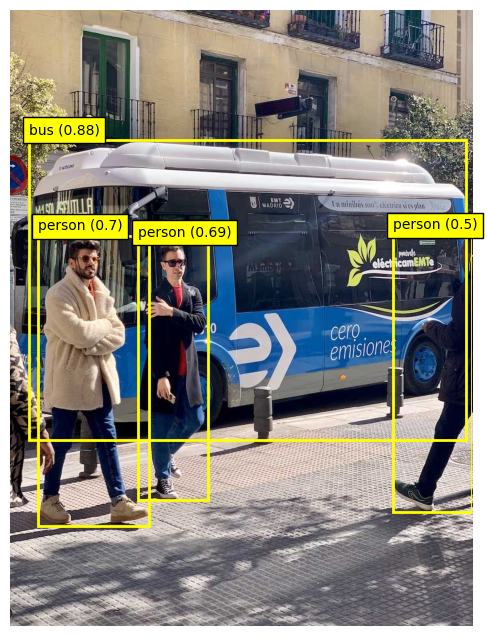

Inference time: 0.03 seconds


In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
start_time = time.time()
# Load the image using PIL
image_path = "img/bus.jpg"
image = Image.open(image_path)

# Convert PIL image to numpy array for matplotlib
image_np = np.array(image)

# Create a matplotlib figure and axis
fig, ax = plt.subplots(1, figsize=(12, 8))

# Display the image
ax.imshow(image_np)

# Iterate over the detected boxes and plot them
for box in result.boxes:
    class_id = result.names[box.cls[0].item()]
    cords = box.xyxy[0].tolist()
    cords = [round(x) for x in cords]
    conf = round(box.conf[0].item(), 2)
    
    # Create a Rectangle patch
    rect = patches.Rectangle((cords[0], cords[1]), cords[2] - cords[0], cords[3] - cords[1],
                             linewidth=2, edgecolor='yellow', facecolor='none')
    
    # Add the patch to the Axes
    ax.add_patch(rect)
    
    # Add label with probability
    label = f"{class_id} ({conf})"
    ax.text(cords[0], cords[1] - 10, label, color='black', fontsize=10, bbox=dict(facecolor='yellow', alpha=1.0))
end_time = time.time()

# Hide axes
ax.axis('off')

# Show the plot
plt.show()
print(f"Inference time: {end_time - start_time:.2f} seconds")
